In [0]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from prettytable import PrettyTable
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

# Import the data

In [0]:
import pandas as pd
final = pd.read_csv("final.csv") #csv file which consists of Amazon food reviews with data cleaning performed upon previously
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(142897) #Gets 1000 reviews of positive and negative scores
neg_2000 = neg.sample(57103)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
print("The shape of grouped data is {}".format(grouped_data.shape))

Observations:
We choose 142897 positive and 57103 negative reviews from the final dataframe obtained after data cleaning process.

In [0]:
import datetime
grouped_data['Time'] = grouped_data['Time'].map(lambda a: datetime.datetime.fromtimestamp(int(a)).strftime('%Y-%m-%d %H:%M:%S'))
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

Observations:
Time based splitting is done on the obtained dataframe.

In [0]:
grouped_data.to_csv("grouped_data_200")

Observations:
Saving this dataframe into a new csv file.

# Utility Functions

In [0]:
#We create a few utility functions whose use is described below


def optimala_gs(x_train,y_train,x_test,y_test,x_cv,y_cv): #This function implements SVM using GridSearchCV and plots confusion matrix
    my_cv = TimeSeriesSplit(n_splits=3).split(x_train)
    param_svc = {'alpha' : [0.0001,0.001,0.01,0.1,1,10,100,1000]} #Parameter alpha for grid search
    model1 = SGDClassifier()
    f1_scorer = make_scorer(f1_score, pos_label='Positive')
    
    gsearch1 = GridSearchCV(estimator = model1, param_grid = param_svc,cv=my_cv, scoring = f1_scorer) #Initiate GridsearchCV
    gsearch1.fit(x_train, y_train) #Fitting the model
    print("The optimal Alpha value found using GridSearchCV is",gsearch1.best_params_['alpha'])
    print("The best CV value found is",gsearch1.best_index_)
    
    gpred1 = gsearch1.predict(x_test) #Predicting test data
    print('\nThe test accuracy of SVM for alpha = %d is %f%%' % (gsearch1.best_params_['alpha'], accuracy_score(y_test, gpred1) * 100))
    print('\nThe test precision of SVM for alpha = %d is %f%%' % (gsearch1.best_params_['alpha'], precision_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test recall of SVM for alpha = %d is %f%%' % (gsearch1.best_params_['alpha'], recall_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test f1 score of SVM for alpha = %d is %f%%' % (gsearch1.best_params_['alpha'], f1_score(y_test,gpred1,pos_label='Positive')*100))
    print('*'*50)
    print(classification_report(y_test,gpred1))
    print("*"*50)
    '''
    Plot confusion matrix
    '''
    y_true = np.array(y_test)
    y_pred = np.array(gpred1)
    labels = ['Negative','Positive']
    print(confusion_matrix(y_test, gpred1))
    cm = ConfusionMatrix(np.where(y_true == 'Positive', True, False), np.where(y_pred == 'Negative',False, True)) #This the confusion matrix of pandas_ml which provides interesting stats.
    confusion_matrix_plot = confusion_matrix(y_test,gpred1) #We are plotting confusion matrix of sklearn
    heatmap = sns.heatmap(confusion_matrix_plot, annot=True,cmap='Blues', fmt='g',xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
    plt.title('Confusion matrix of the classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("*"*50)
    print("The True Positive Rate observed is",cm.TPR) #This prints the True Positive Rate of the confusion matrix (using pandas_ml confusion matrix).
    print("The True Negative Rate observed is",cm.TNR)
    print("The False Positive Rate observed is",cm.FPR)
    print("The False Negative Rate observed is",cm.FNR)
    print("*"*50)
    print("The stats observed for confusion matrix are:")
    cm.print_stats()#Prints all the stats of the confusion matrix plotted (using pandas_ml confusion matrix).
    
    print('\n')
    print('*'*28,"Plotting Alpha, Error and number of non zero elements",'*'*28)
    test_error=[]
    train_error=[]
    for i in param_svc['alpha']:
        model = SGDClassifier(alpha=i)
        model.fit(x_train,y_train)
        train_error.append(1-accuracy_score(y_cv, model.predict(x_cv)))
        test_error.append(1-accuracy_score(y_test, model.predict(x_test)))

    
    plt.figure(1)
    plt.plot([a for a in param_svc['alpha']], train_error)

    for xy in zip([a for a in param_svc['alpha']], np.round(train_error,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
        
    plt.title('Alpha vs Train Error')
    plt.xlabel('Alpha')
    plt.ylabel('Train Error')
    plt.show()
    
    plt.figure(2)
    plt.plot([a for a in param_svc['alpha']], test_error)

    for xy in zip([a for a in param_svc['alpha']], np.round(test_error,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
        
    plt.title('Alpha vs Test Error')
    plt.xlabel('ALpha')
    plt.ylabel('Test Error')
    plt.show()
    
    print('*'*80)
    print("The value of alpha is                   : ", [a for a in param_svc['alpha']])
    print("The train error for each alpha value is : ", np.round(train_error,3))
    print("The test error for each alpha value is : ", np.round(test_error,3))
    
def optimala_rs(x_train,y_train,x_test,y_test,cv): #This function implements SVM using RandomizedSearchCV and plots confusion matrix
    my_cv = TimeSeriesSplit(n_splits=3).split(x_train)
    param_svc = {'alpha' : [0.0001,0.001,0.01,0.1,1,10,100,1000]}
    model1 = SGDClassifier()
    f1_scorer = make_scorer(f1_score, pos_label='Positive')
    
    rsearch1 = RandomizedSearchCV(model1,param_svc,cv=cv, scoring = f1_scorer,n_iter=8)
    rsearch1.fit(x_train, y_train)
    print("The optimal Alpha value found using RandomizedSearchCV is",rsearch1.best_params_['alpha'])
    
    gpred1 = rsearch1.predict(x_test)
    print('\nThe test accuracy of SVM for alpha = %d is %f%%' % (rsearch1.best_params_['alpha'], accuracy_score(y_test, gpred1) * 100))
    print('\nThe test precision of SVM for alpha = %d is %f%%' % (rsearch1.best_params_['alpha'], precision_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test recall of SVM for alpha = %d is %f%%' % (rsearch1.best_params_['alpha'], recall_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test f1 score of SVM for alpha = %d is %f%%' % (rsearch1.best_params_['alpha'], f1_score(y_test,gpred1,pos_label='Positive')*100))
    print('*'*50)
    print(classification_report(y_test,gpred1))
    print("*"*50)
    '''
    Plot confusion matrix
    '''
    y_true = np.array(y_test)
    y_pred = np.array(gpred1)
    labels = ['Negative','Positive']
    print(confusion_matrix(y_test, gpred1))
    cm = ConfusionMatrix(np.where(y_true == 'Positive', True, False), np.where(y_pred == 'Negative',False, True)) #This the confusion matrix of pandas_ml which provides interesting stats.
    confusion_matrix_plot = confusion_matrix(y_test,gpred1) #We are plotting confusion matrix of sklearn
    heatmap = sns.heatmap(confusion_matrix_plot, annot=True,cmap='Blues', fmt='g',xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
    plt.title('Confusion matrix of the classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("*"*50)
    print("The True Positive Rate observed is",cm.TPR) #This prints the True Positive Rate of the confusion matrix (using pandas_ml confusion matrix).
    print("The True Negative Rate observed is",cm.TNR)
    print("The False Positive Rate observed is",cm.FPR)
    print("The False Negative Rate observed is",cm.FNR)
    print("*"*50)
    print("The stats observed for confusion matrix are:")
    cm.print_stats()#Prints all the stats of the confusion matrix plotted (using pandas_ml confusion matrix).
    
def get_top_feats(x_train, y_train): #This function gets the feature importances in the form of a dataframe
    count_vect = CountVectorizer() #Initialise count vectorizer
    data_train = count_vect.fit_transform(x_train['CleanedText'].values)
    X_train, X_test, y_train, y_test = train_test_split(data_train, y_train, random_state=0) #Train test splitting
    standard_train = StandardScaler(with_mean=False).fit_transform(X_train) #Standardize data
    
    my_cv = TimeSeriesSplit(n_splits=2).split(X_train)
    param_grid = {'alpha' : [0.0001,0.001,0.01,0.1,1,10,100,1000]} #Set parameters for gridsearch
    model1 = SGDClassifier(penalty='l2') #Initialize the model
    f1_scorer = make_scorer(f1_score, pos_label='Positive') #Set positive parameter for F1 score
    gsearch1 = GridSearchCV(estimator = model1, param_grid = param_grid,cv=my_cv, scoring = f1_scorer) #Perform grid search
    gsearch1.fit(standard_train,y_train)
    gs = gsearch1.best_estimator_
    acc = gsearch1.score(X_test, y_test) #Stores accuracy value in acc
    print ('Model Accuracy:',acc)
    
    words = count_vect.get_feature_names() #Gets all the words in the vocabulary
    print('The number of words available are', len(words))
    gs.fit(standard_train,y_train)
    coef = gs.coef_.tolist()[0] #Get the coefficients of features
    df = pd.DataFrame({'Words': words, 'Coefficients':coef}) #Create a dataframe
    return df

def svc_gs(x_train,y_train,x_test,y_test,x_cv,y_cv): #This function implements SVC with RBF Kernel
    my_cv = TimeSeriesSplit(n_splits=3).split(x_train)
    param_svc = {'C' : [0.001,0.01,0.1,1,10,100,1000],'gamma' : [0.001,0.01,0.1,1,10,100]}
    model1 = SVC()
    f1_scorer = make_scorer(f1_score, pos_label='Positive')
    
    gsearch1 = GridSearchCV(estimator = model1, param_grid = param_svc,cv=my_cv, scoring = f1_scorer)
    gsearch1.fit(x_train, y_train)
    print("The optimal C value found using GridSearchCV is",gsearch1.best_params_['C'])
    print("The optimal Sigma value found using GridSearchCV is",1/gsearch1.best_params_['gamma'])
    print("The best CV value found is",gsearch1.best_index_)
    
    gpred1 = gsearch1.predict(x_test)
    print('\nThe test accuracy of SVM for C = %d is %f%%' % (gsearch1.best_params_['C'], accuracy_score(y_test, gpred1) * 100))
    print('\nThe test precision of SVM for C = %d is %f%%' % (gsearch1.best_params_['C'], precision_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test recall of SVM for C = %d is %f%%' % (gsearch1.best_params_['C'], recall_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test f1 score of SVM for C = %d is %f%%' % (gsearch1.best_params_['C'], f1_score(y_test,gpred1,pos_label='Positive')*100))
    print('*'*50)
    print(classification_report(y_test,gpred1))
    print("*"*50)
    '''
    Plot confusion matrix
    '''
    y_true = np.array(y_test)
    y_pred = np.array(gpred1)
    labels = ['Negative','Positive']
    print(confusion_matrix(y_test, gpred1))
    cm = ConfusionMatrix(np.where(y_true == 'Positive', True, False), np.where(y_pred == 'Negative',False, True)) #This the confusion matrix of pandas_ml which provides interesting stats.
    confusion_matrix_plot = confusion_matrix(y_test,gpred1) #We are plotting confusion matrix of sklearn
    heatmap = sns.heatmap(confusion_matrix_plot, annot=True,cmap='Blues', fmt='g',xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
    plt.title('Confusion matrix of the classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("*"*50)
    print("The True Positive Rate observed is",cm.TPR) #This prints the True Positive Rate of the confusion matrix (using pandas_ml confusion matrix).
    print("The True Negative Rate observed is",cm.TNR)
    print("The False Positive Rate observed is",cm.FPR)
    print("The False Negative Rate observed is",cm.FNR)
    print("*"*50)
    print("The stats observed for confusion matrix are:")
    cm.print_stats()#Prints all the stats of the confusion matrix plotted (using pandas_ml confusion matrix).
    

**Observations:**

1) The first function finds the optimal alpha value for SGDClassifier, plots confusion matrix and lists all of its stats using GridsearchCV.

2) The second function does the same using RandomizedsearchCV.

3) The third function returns a dataframe with all the important words in both positive and negative reviews.

4) The fourth function performs SVC with RBF by selecting the right 'C' and 'gamma'.

# Feature Importance

In [0]:
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
scores = grouped_data['Score']

Observations: There are a few Nan valued data in the dataset. Also there are a few indexes missing. All these are resolved and all the words are obtained.

In [39]:
df = get_top_feats(grouped_data, scores)

Model Accuracy: 0.8914746310895492
The number of words available are 53788


Observations: A dataframe is created with all the words and their coefficients.

In [40]:
df.sort_values(['Coefficients'], ascending=False).head(7)

,Coefficients,Words
20216,0.239345,great
27549,0.198717,love
4394,0.168246,best
19791,0.159993,good
12302,0.137308,delici
35046,0.112754,perfect
16025,0.110957,excel


Observations: Top 7 best words for positive reviews are 'great', 'love', 'best', 'good', 'delici', 'perfect', 'excel'.

In [41]:
df.sort_values(['Coefficients'], ascending=True).head(7)

,Coefficients,Words
13200,-0.163027,disappoint
52776,-0.102537,worst
47038,-0.093221,terribl
49671,-0.090840,unfortun
39573,-0.089086,return
3144,-0.084017,aw
22333,-0.083365,horribl


Observations: Top 7 best words for negative reviews are 'disappoint', 'worst', 'terribl', 'unfortun', 'return', 'aw', 'horribl'.

# Bag of Words

In [5]:
import pandas as pd
grouped_data = pd.read_csv("grouped_data_200.csv")
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (200000, 13)


In [18]:
grouped_data['Score'].value_counts()

Positive    142897
Negative     57103
Name: Score, dtype: int64

Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time.

In [0]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

Observations:
The data is split into train, test and cross validate.

In [20]:
count_vect = CountVectorizer()
vocab = count_vect.fit(x_train['CleanedText'].values.astype('U'))
data_train = count_vect.transform(x_train['CleanedText'].values.astype('U'))
data_test = count_vect.transform(x_test['CleanedText'].values.astype('U'))
data_cv = count_vect.transform(x_cv['CleanedText'].values.astype('U'))
print("The shape of train data for BOW is {}".format(data_train.shape))
print("The shape of test data for BOW is {}".format(data_test.shape))
print("The shape of cv data for BOW is {}".format(data_cv.shape))

The shape of train data for BOW is (98000, 38101)
The shape of test data for BOW is (60000, 38101)
The shape of cv data for BOW is (42000, 38101)


Observations:
We build out Bag of words vocabulary only on train data and get vectors of train and test data.

In [21]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
std_vocab = std.fit(data_train)
standard_train = std.transform(data_train)
standard_test = std.transform(data_test)
standard_cv = std.transform(data_cv)
print("The type of standard_train is ",type(data_train))
print("The type of standard_test is ",type(data_test))
print("The shape of standard_train is ",standard_train.get_shape())
print("The shape of standard_test is ",standard_test.get_shape())
print("The shape of standard_cv is ",standard_cv.get_shape())

The type of standard_train is  <class 'scipy.sparse.csr.csr_matrix'>
The type of standard_test is  <class 'scipy.sparse.csr.csr_matrix'>
The shape of standard_train is  (98000, 38101)
The shape of standard_test is  (60000, 38101)
The shape of standard_cv is  (42000, 38101)


Observations: The data is standardized.

The optimal Alpha value found using GridSearchCV is 1
The best CV value found is 4

The test accuracy of SVM for alpha = 1 is 87.076667%

The test precision of SVM for alpha = 1 is 86.769308%

The test recall of SVM for alpha = 1 is 96.597685%

The test f1 score of SVM for alpha = 1 is 91.420099%
**************************************************
             precision    recall  f1-score   support

   Negative       0.88      0.63      0.74     17235
   Positive       0.87      0.97      0.91     42765

avg / total       0.87      0.87      0.86     60000

**************************************************
[[10936  6299]
 [ 1455 41310]]


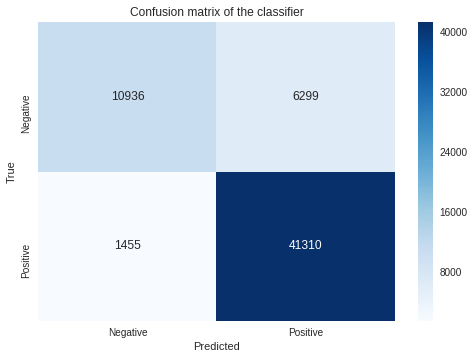

**************************************************
The True Positive Rate observed is 0.9659768502279902
The True Negative Rate observed is 0.6345227734261677
The False Positive Rate observed is 0.3654772265738323
The False Negative Rate observed is 0.03402314977200982
**************************************************
The stats observed for confusion matrix are:
population: 60000
P: 42765
N: 17235
PositiveTest: 47609
NegativeTest: 12391
TP: 41310
TN: 10936
FP: 6299
FN: 1455
TPR: 0.9659768502279902
TNR: 0.6345227734261677
PPV: 0.8676930832405637
NPV: 0.8825760632717294
FPR: 0.3654772265738323
FDR: 0.13230691675943623
FNR: 0.03402314977200982
ACC: 0.8707666666666667
F1_score: 0.9142009870095381
MCC: 0.6712200385268294
informedness: 0.6004996236541578
markedness: 0.7502691465122933
prevalence: 0.71275
LRP: 2.6430562015684096
LRN: 0.053620060929095575
DOR: 49.29230134712924
FOR: 0.11742393672827052


**************************** Plotting Alpha, Error and number of non zero elements ******

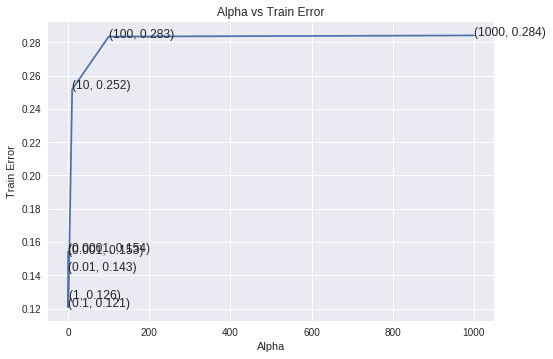

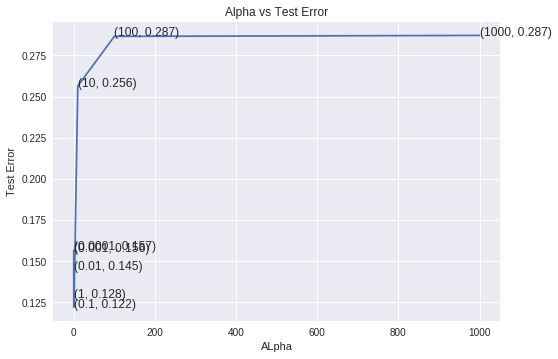

********************************************************************************
The value of alpha is                   :  [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
The train error for each alpha value is :  [0.154 0.153 0.143 0.121 0.126 0.252 0.283 0.284]
The test error for each alpha value is :  [0.157 0.156 0.145 0.122 0.128 0.256 0.287 0.287]


In [22]:
optimala_gs(standard_train, y_train, standard_test, y_test, standard_cv, y_cv)

The optimal Alpha value found using RandomizedSearchCV is 0.1

The test accuracy of SVM for alpha = 0 is 87.756667%

The test precision of SVM for alpha = 0 is 89.932129%

The test recall of SVM for alpha = 0 is 93.263183%

The test f1 score of SVM for alpha = 0 is 91.567371%
**************************************************
             precision    recall  f1-score   support

   Negative       0.82      0.74      0.78     17235
   Positive       0.90      0.93      0.92     42765

avg / total       0.88      0.88      0.88     60000

**************************************************
[[12770  4465]
 [ 2881 39884]]


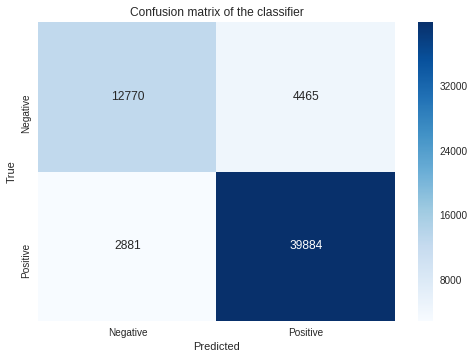

**************************************************
The True Positive Rate observed is 0.9326318250906115
The True Negative Rate observed is 0.7409341456338845
The False Positive Rate observed is 0.25906585436611546
The False Negative Rate observed is 0.06736817490938851
**************************************************
The stats observed for confusion matrix are:
population: 60000
P: 42765
N: 17235
PositiveTest: 44349
NegativeTest: 15651
TP: 39884
TN: 12770
FP: 4465
FN: 2881
TPR: 0.9326318250906115
TNR: 0.7409341456338845
PPV: 0.8993212924755913
NPV: 0.8159223052840074
FPR: 0.25906585436611546
FDR: 0.10067870752440866
FNR: 0.06736817490938851
ACC: 0.8775666666666667
F1_score: 0.9156737149023119
MCC: 0.694092031527106
informedness: 0.6735659707244959
markedness: 0.7152435977595988
prevalence: 0.71275
LRP: 3.599979732460625
LRN: 0.09092329636361089
DOR: 39.59359016267915
FOR: 0.18407769471599258


In [23]:
optimala_rs(standard_train, y_train, standard_test, y_test,4)

# Bag of Words using SVC

In [6]:
p = grouped_data.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_60k = pos.sample(30000) #Gets 1000 reviews of positive and negative scores
neg_40k = neg.sample(20000)
grouped_data = pd.concat([pos_60k, neg_40k], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (50000, 13)


Observations: Create a new dataset with 50000 reviews and sort it based on time.

In [7]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)
count_vect = CountVectorizer()
vocab = count_vect.fit(x_train['CleanedText'].values.astype('U'))
data_train = count_vect.transform(x_train['CleanedText'].values.astype('U'))
data_test = count_vect.transform(x_test['CleanedText'].values.astype('U'))
data_cv = count_vect.transform(x_cv['CleanedText'].values.astype('U'))
print("The shape of train data for BOW is {}".format(data_train.shape))
print("The shape of test data for BOW is {}".format(data_test.shape))
print("The shape of cv data for BOW is {}".format(data_cv.shape))
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
std_vocab = std.fit(data_train)
standard_train = std.transform(data_train)
standard_test = std.transform(data_test)
standard_cv = std.transform(data_cv)
print("The type of standard_train is ",type(data_train))
print("The type of standard_test is ",type(data_test))
print("The shape of standard_train is ",standard_train.get_shape())
print("The shape of standard_test is ",standard_test.get_shape())
print("The shape of standard_cv is ",standard_cv.get_shape())

The shape of train data for BOW is (24500, 19954)
The shape of test data for BOW is (15000, 19954)
The shape of cv data for BOW is (10500, 19954)
The type of standard_train is  <class 'scipy.sparse.csr.csr_matrix'>
The type of standard_test is  <class 'scipy.sparse.csr.csr_matrix'>
The shape of standard_train is  (24500, 19954)
The shape of standard_test is  (15000, 19954)
The shape of standard_cv is  (10500, 19954)


Observations: Perform vectorization, standardization on the train, test data.

The optimal C value found using GridSearchCV is 10
The optimal Sigma value found using GridSearchCV is 1000.0
The best CV value found is 24

The test accuracy of SVM for C = 10 is 68.133333%

The test precision of SVM for C = 10 is 66.229684%

The test recall of SVM for C = 10 is 95.839805%

The test f1 score of SVM for C = 10 is 78.329858%
**************************************************
             precision    recall  f1-score   support

   Negative       0.81      0.26      0.40      5986
   Positive       0.66      0.96      0.78      9014

avg / total       0.72      0.68      0.63     15000

**************************************************
[[1581 4405]
 [ 375 8639]]


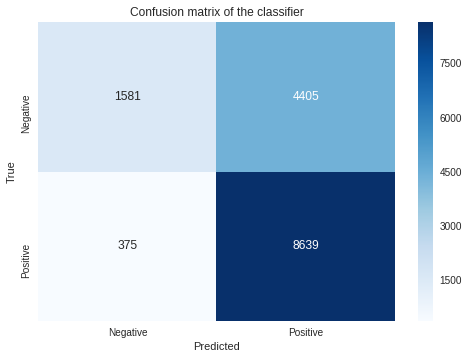

**************************************************
The True Positive Rate observed is 0.9583980474816951
The True Negative Rate observed is 0.2641162712996993
The False Positive Rate observed is 0.7358837287003007
The False Negative Rate observed is 0.04160195251830486
**************************************************
The stats observed for confusion matrix are:
population: 15000
P: 9014
N: 5986
PositiveTest: 13044
NegativeTest: 1956
TP: 8639
TN: 1581
FP: 4405
FN: 375
TPR: 0.9583980474816951
TNR: 0.2641162712996993
PPV: 0.6622968414596749
NPV: 0.808282208588957
FPR: 0.7358837287003007
FDR: 0.33770315854032507
FNR: 0.04160195251830486
ACC: 0.6813333333333333
F1_score: 0.7832985764801886
MCC: 0.32359013698561184
informedness: 0.2225143187813945
markedness: 0.470579050048632
prevalence: 0.6009333333333333
LRP: 1.3023770061805735
LRN: 0.157513781008585
DOR: 8.268336889897842
FOR: 0.19171779141104295


In [8]:
svc_gs(standard_train, y_train, standard_test, y_test, standard_cv, y_cv)

# TFIDF

In [3]:
import pandas as pd
grouped_data = pd.read_csv("grouped_data_200.csv")
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (200000, 12)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time.

In [0]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

Observations: Data is split into train, test and cross validate

In [6]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit(x_train['CleanedText'].values.astype('U')) #Converts to a sparse matrix of TF-IDF vectors.
train_tf_idf = tf_idf_vect.transform(x_train['CleanedText'].values.astype('U'))
test_tf_idf = tf_idf_vect.transform(x_test['CleanedText'].values.astype('U'))
cv_tf_idf = tf_idf_vect.transform(x_cv['CleanedText'].values.astype('U'))
print("the type of count vectorizer ",type(train_tf_idf))
print("The shape of train_tf_idf ",train_tf_idf.get_shape())
print("The shape of test_tf_idf ", test_tf_idf.get_shape())
print("The shape of cv_tf_idf ", cv_tf_idf.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train_tf_idf  (98000, 1270507)
The shape of test_tf_idf  (60000, 1270507)
The shape of cv_tf_idf  (42000, 1270507)


Observations:
Vocabulary of TF-IDF is trained for train data and vectors for train and test data are obtained.

In [8]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
std_vocab = std.fit(train_tf_idf)
standardized_train = std.transform(train_tf_idf)
standardized_test = std.transform(test_tf_idf)
standardized_cv = std.transform(cv_tf_idf)
print("The type of standard_train is ",type(train_tf_idf))
print("The type of standard_test is ",type(test_tf_idf))
print("The shape of standard_train is ",standardized_train.get_shape())
print("The shape of standard_test is ",standardized_test.get_shape())
print("The shape of standard_cv is ",standardized_cv.get_shape())

The type of standard_train is  <class 'scipy.sparse.csr.csr_matrix'>
The type of standard_test is  <class 'scipy.sparse.csr.csr_matrix'>
The shape of standard_train is  (98000, 1270507)
The shape of standard_test is  (60000, 1270507)
The shape of standard_cv is  (42000, 1270507)


Observations:
Data is standardized.

The optimal Alpha value found using GridSearchCV is 1
The best CV value found is 4

The test accuracy of SVM for alpha = 1 is 85.083333%

The test precision of SVM for alpha = 1 is 86.100139%

The test recall of SVM for alpha = 1 is 94.294400%

The test f1 score of SVM for alpha = 1 is 90.011161%
**************************************************
             precision    recall  f1-score   support

   Negative       0.81      0.62      0.71     17235
   Positive       0.86      0.94      0.90     42765

avg / total       0.85      0.85      0.84     60000

**************************************************
[[10725  6510]
 [ 2440 40325]]


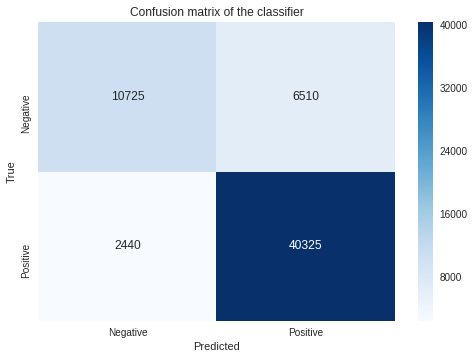

**************************************************
The True Positive Rate observed is 0.9429439962586227
The True Negative Rate observed is 0.6222802436901653
The False Positive Rate observed is 0.3777197563098346
The False Negative Rate observed is 0.057056003741377294
**************************************************
The stats observed for confusion matrix are:
population: 60000
P: 42765
N: 17235
PositiveTest: 46835
NegativeTest: 13165
TP: 40325
TN: 10725
FP: 6510
FN: 2440
TPR: 0.9429439962586227
TNR: 0.6222802436901653
PPV: 0.8610013878509661
NPV: 0.8146600835548804
FPR: 0.3777197563098346
FDR: 0.13899861214903383
FNR: 0.057056003741377294
ACC: 0.8508333333333333
F1_score: 0.9001116071428571
MCC: 0.617980777725367
informedness: 0.5652242399487881
markedness: 0.6756614714058466
prevalence: 0.71275
LRP: 2.496411639864418
LRN: 0.09168859901936016
DOR: 27.22706712245977
FOR: 0.18533991644511963


**************************** Plotting Alpha, Error and number of non zero elements *******

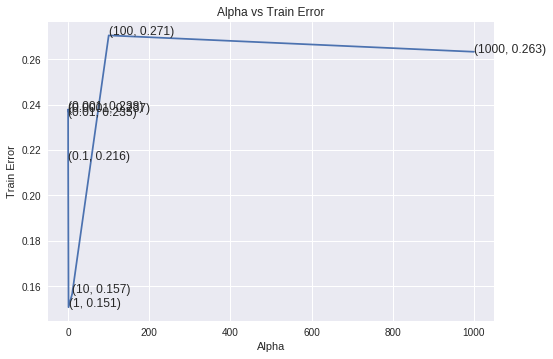

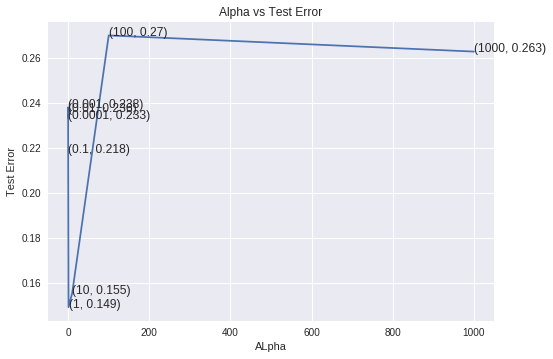

********************************************************************************
The value of alpha is                   :  [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
The train error for each alpha value is :  [0.237 0.238 0.235 0.216 0.151 0.157 0.271 0.263]
The test error for each alpha value is :  [0.233 0.238 0.236 0.218 0.149 0.155 0.27  0.263]


In [9]:
optimala_gs(standardized_train, y_train, standardized_test, y_test, standardized_cv, y_cv)

The optimal Alpha value found using RandomizedSearchCV is 1

The test accuracy of SVM for alpha = 1 is 85.058333%

The test precision of SVM for alpha = 1 is 86.077192%

The test recall of SVM for alpha = 1 is 94.287385%

The test f1 score of SVM for alpha = 1 is 89.995425%
**************************************************
             precision    recall  f1-score   support

   Negative       0.81      0.62      0.71     17235
   Positive       0.86      0.94      0.90     42765

avg / total       0.85      0.85      0.84     60000

**************************************************
[[10713  6522]
 [ 2443 40322]]


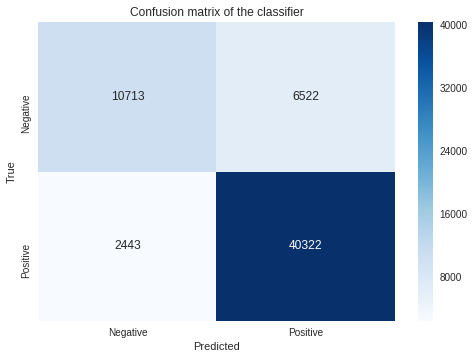

**************************************************
The True Positive Rate observed is 0.9428738454343505
The True Negative Rate observed is 0.6215839860748477
The False Positive Rate observed is 0.3784160139251523
The False Negative Rate observed is 0.05712615456564948
**************************************************
The stats observed for confusion matrix are:
population: 60000
P: 42765
N: 17235
PositiveTest: 46844
NegativeTest: 13156
TP: 40322
TN: 10713
FP: 6522
FN: 2443
TPR: 0.9428738454343505
TNR: 0.6215839860748477
PPV: 0.8607719238322944
NPV: 0.8143052599574339
FPR: 0.3784160139251523
FDR: 0.13922807616770558
FNR: 0.05712615456564948
ACC: 0.8505833333333334
F1_score: 0.8999542456672879
MCC: 0.6172945838603207
informedness: 0.5644578315091981
markedness: 0.6750771837897283
prevalence: 0.71275
LRP: 2.491633046007518
LRN: 0.09190416073359178
DOR: 27.11121048404073
FOR: 0.18569474004256614


In [10]:
optimala_rs(standardized_train, y_train, standardized_test, y_test, 4)

# Word2Vec

In [5]:
import pandas as pd
grouped_data = pd.read_csv("grouped_data_200.csv")
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (200000, 13)


In [0]:
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores = grouped_data['Score']

In [0]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

In [13]:
list_of_sent=[]
for sent in x_train['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(x_train['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

use buy canada vacat havent back year couldnt find store thrill find stuff amaz simpli add fresh cream prepar whip cream whip remain stiff sever day particular handi put top anoth dessert wont serv next day one creat leftov whip cream usual fall flat get runni whipit youll love tad expens worth believ
*****************************************************************
['use', 'buy', 'canada', 'vacat', 'havent', 'back', 'year', 'couldnt', 'find', 'store', 'thrill', 'find', 'stuff', 'amaz', 'simpli', 'add', 'fresh', 'cream', 'prepar', 'whip', 'cream', 'whip', 'remain', 'stiff', 'sever', 'day', 'particular', 'handi', 'put', 'top', 'anoth', 'dessert', 'wont', 'serv', 'next', 'day', 'one', 'creat', 'leftov', 'whip', 'cream', 'usual', 'fall', 'flat', 'get', 'runni', 'whipit', 'youll', 'love', 'tad', 'expens', 'worth', 'believ']


In [14]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=200, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  12684
sample words  ['lemon', 'lime', 'juic', 'search', 'idea', 'mani', 'includ', 'minc', 'garlic', 'ginger', 'etc', 'premad', 'teriyaki', 'sauc', 'liquid', 'penetr', 'half']


In [15]:
sent_vectors = [];
sent_list = []
for sent in x_test['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            vec = w2v_train.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

59998
200


In [16]:
sent_vectors_train = [];
sent_list = []
for sent in x_train['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            vec = w2v_train.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

97995
200


In [17]:
sent_vectors_cv = [];
sent_list = []
for sent in x_cv['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            vec = w2v_train.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

41998
200


In [18]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
std_vocab = std.fit(sent_vectors_train)
standardized_train = std.transform(sent_vectors_train)
standardized_test = std.transform(sent_vectors)
standardized_cv = std.transform(sent_vectors_cv)
print("The type of standard_train is ",type(standardized_train))
print("The type of standard_test is ",type(standardized_test))
print("The shape of standard_train is ",standardized_train.shape)
print("The shape of standard_test is ",standardized_test.shape)
print("The shape of standard_cv is ",standardized_cv.shape)

The type of standard_train is  <class 'numpy.ndarray'>
The type of standard_test is  <class 'numpy.ndarray'>
The shape of standard_train is  (97995, 200)
The shape of standard_test is  (59998, 200)
The shape of standard_cv is  (41998, 200)


The optimal Alpha value found using GridSearchCV is 0.1
The best CV value found is 3

The test accuracy of SVM for alpha = 0 is 87.034568%

The test precision of SVM for alpha = 0 is 88.791102%

The test recall of SVM for alpha = 0 is 93.677678%

The test f1 score of SVM for alpha = 0 is 91.168958%
**************************************************
             precision    recall  f1-score   support

   Negative       0.82      0.70      0.76     17134
   Positive       0.89      0.94      0.91     42864

avg / total       0.87      0.87      0.87     59998

**************************************************
[[12065  5069]
 [ 2710 40154]]


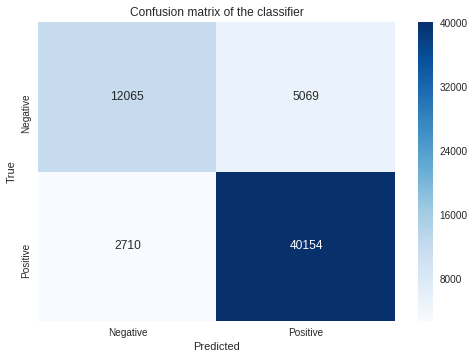

**************************************************
The True Positive Rate observed is 0.9367767823814857
The True Negative Rate observed is 0.7041554803315047
The False Positive Rate observed is 0.2958445196684954
The False Negative Rate observed is 0.06322321761851438
**************************************************
The stats observed for confusion matrix are:
population: 59998
P: 42864
N: 17134
PositiveTest: 45223
NegativeTest: 14775
TP: 40154
TN: 12065
FP: 5069
FN: 2710
TPR: 0.9367767823814857
TNR: 0.7041554803315047
PPV: 0.8879110187294076
NPV: 0.8165820642978003
FPR: 0.2958445196684954
FDR: 0.1120889812705924
FNR: 0.06322321761851438
ACC: 0.870345678189273
F1_score: 0.9116895796201483
MCC: 0.6719615656942582
informedness: 0.6409322627129903
markedness: 0.704493083027208
prevalence: 0.7144238141271376
LRP: 3.1664496723859488
LRN: 0.08978587738712186
DOR: 35.26667850817391
FOR: 0.18341793570219966


**************************** Plotting Alpha, Error and number of non zero elements

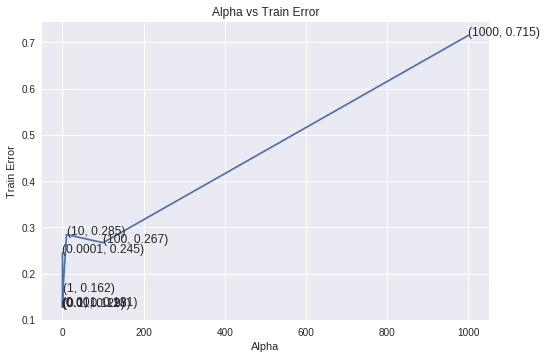

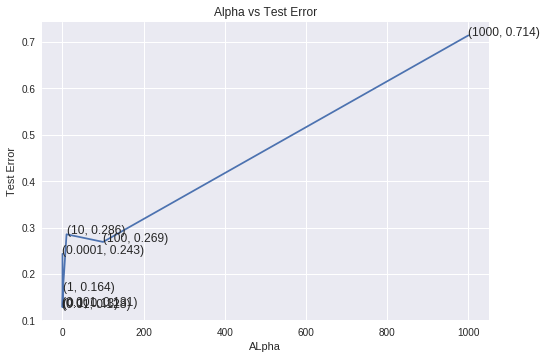

********************************************************************************
The value of alpha is                   :  [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
The train error for each alpha value is :  [0.245 0.131 0.128 0.129 0.162 0.285 0.267 0.715]
The test error for each alpha value is :  [0.243 0.131 0.128 0.13  0.164 0.286 0.269 0.714]


In [19]:
optimala_gs(standardized_train, y_train, standardized_test, y_test, standardized_cv, y_cv)

The optimal Alpha value found using RandomizedSearchCV is 0.01

The test accuracy of SVM for alpha = 0 is 87.399580%

The test precision of SVM for alpha = 0 is 89.477569%

The test recall of SVM for alpha = 0 is 93.339399%

The test f1 score of SVM for alpha = 0 is 91.367695%
**************************************************
             precision    recall  f1-score   support

   Negative       0.81      0.73      0.77     17134
   Positive       0.89      0.93      0.91     42864

avg / total       0.87      0.87      0.87     59998

**************************************************
[[12429  4705]
 [ 2855 40009]]


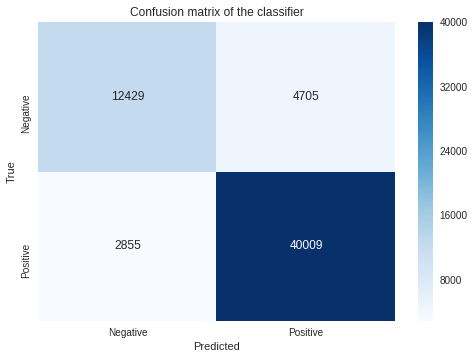

**************************************************
The True Positive Rate observed is 0.9333939902948861
The True Negative Rate observed is 0.7253997898914439
The False Positive Rate observed is 0.27460021010855606
The False Negative Rate observed is 0.06660600970511385
**************************************************
The stats observed for confusion matrix are:
population: 59998
P: 42864
N: 17134
PositiveTest: 44714
NegativeTest: 15284
TP: 40009
TN: 12429
FP: 4705
FN: 2855
TPR: 0.9333939902948861
TNR: 0.7253997898914439
PPV: 0.8947756854676387
NPV: 0.8132033499084009
FPR: 0.27460021010855606
FDR: 0.10522431453236122
FNR: 0.06660600970511385
ACC: 0.8739957998599953
F1_score: 0.9136769508324009
MCC: 0.6829437641622133
informedness: 0.65879378018633
markedness: 0.7079790353760398
prevalence: 0.7144238141271376
LRP: 3.399101515348051
LRN: 0.09181972566476955
DOR: 37.019295045141455
FOR: 0.18679665009159907


In [21]:
optimala_rs(standardized_train, y_train, standardized_test, y_test, 3)

# TFIDF Word2Vec

In [3]:
import pandas as pd
grouped_data = pd.read_csv("grouped_data_200.csv")
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (10000, 12)


Observations:
Import a csv file containing 20000 data points and form a new dataframe with 10000 data points containing 6000 positive and 4000 negative points. Time based splitting is performed upon.

In [0]:
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores = grouped_data['Score']

In [0]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

Observations: Data is split into train, test and cross validate.

In [22]:
list_of_sent=[]
for sent in x_train['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(x_train['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

use buy canada vacat havent back year couldnt find store thrill find stuff amaz simpli add fresh cream prepar whip cream whip remain stiff sever day particular handi put top anoth dessert wont serv next day one creat leftov whip cream usual fall flat get runni whipit youll love tad expens worth believ
*****************************************************************
['use', 'buy', 'canada', 'vacat', 'havent', 'back', 'year', 'couldnt', 'find', 'store', 'thrill', 'find', 'stuff', 'amaz', 'simpli', 'add', 'fresh', 'cream', 'prepar', 'whip', 'cream', 'whip', 'remain', 'stiff', 'sever', 'day', 'particular', 'handi', 'put', 'top', 'anoth', 'dessert', 'wont', 'serv', 'next', 'day', 'one', 'creat', 'leftov', 'whip', 'cream', 'usual', 'fall', 'flat', 'get', 'runni', 'whipit', 'youll', 'love', 'tad', 'expens', 'worth', 'believ']


Observations:
Prints the corresponding split words in a given review.

In [23]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=200, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  12684
sample words  ['lemon', 'lime', 'juic', 'search', 'idea', 'mani', 'includ', 'minc', 'garlic', 'ginger', 'etc', 'premad', 'teriyaki', 'sauc', 'liquid', 'penetr', 'half']


Observations:
Word2Vec model is built. We can see the number of times a word occured minimum 5 times.

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit(x_train['CleanedText'].values) #Converts to a sparse matrix of TF-IDF vectors.
train_tf_idf = tf_idf_vect.transform(x_train['CleanedText'].values)
test_tf_idf = tf_idf_vect.transform(x_test['CleanedText'].values)
cv_tf_idf = tf_idf_vect.transform(x_cv['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tfidf_feat, list(tf_idf_vect.idf_)))

Observations:
We build the vocabulary of TF-IDF on train data and obtain the vectors of train and test data.

In [25]:
sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
sent_list = []
for sent in x_train['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_train_words:
            try:
                vec = w2v_train.wv[word] # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
    row += 1
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

97995
200


Observations:
The vector form of train data is obtained.

In [26]:
sent_vectors_test = [];
row=0
sent_list = []
for sent in x_test['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            try:
                vec = w2v_train.wv[word] #Gets the corresponding vector for the word
                tf_idf = tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                i += tf_idf
            except:
                pass
    if i != 0:
        sent_vec /= i
    sent_vectors_test.append(sent_vec)
    row+=1
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

59998
200


In [27]:
sent_vectors_cv = [];
row=0
sent_list = []
for sent in x_cv['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            try:
                vec = w2v_train.wv[word] #Gets the corresponding vector for the word
                tf_idf = tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                i += tf_idf
            except:
                pass
    if i != 0:
        sent_vec /= i
    sent_vectors_cv.append(sent_vec)
    row+=1
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

41998
200


Observations:
The vector form of test data is obtained.

In [28]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
std_vocab = std.fit(sent_vectors_train)
standardized_train = std.transform(sent_vectors_train)
standardized_test = std.transform(sent_vectors_test)
standardized_cv = std.transform(sent_vectors_cv)
print("The type of standard_train is ",type(standardized_train))
print("The type of standard_test is ",type(standardized_test))
print("The shape of standard_train is ",standardized_train.shape)
print("The shape of standard_test is ",standardized_test.shape)
print("The shape of standard_cv is ",standardized_cv.shape)

The type of standard_train is  <class 'numpy.ndarray'>
The type of standard_test is  <class 'numpy.ndarray'>
The shape of standard_train is  (97995, 200)
The shape of standard_test is  (59998, 200)
The shape of standard_cv is  (41998, 200)


Observations: Data is standardized.

The optimal Alpha value found using GridSearchCV is 0.01
The best CV value found is 2

The test accuracy of SVM for alpha = 0 is 85.086170%

The test precision of SVM for alpha = 0 is 87.182073%

The test recall of SVM for alpha = 0 is 92.763158%

The test f1 score of SVM for alpha = 0 is 89.886066%
**************************************************
             precision    recall  f1-score   support

   Negative       0.78      0.66      0.72     17134
   Positive       0.87      0.93      0.90     42864

avg / total       0.85      0.85      0.85     59998

**************************************************
[[11288  5846]
 [ 3102 39762]]


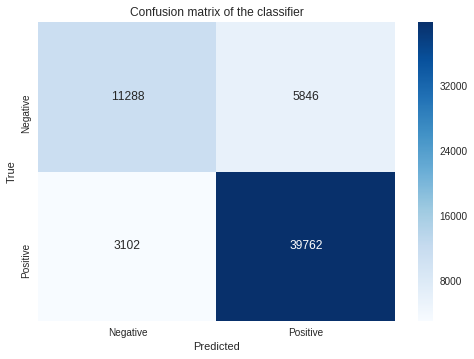

**************************************************
The True Positive Rate observed is 0.9276315789473685
The True Negative Rate observed is 0.6588070503093265
The False Positive Rate observed is 0.34119294969067354
The False Negative Rate observed is 0.07236842105263158
**************************************************
The stats observed for confusion matrix are:
population: 59998
P: 42864
N: 17134
PositiveTest: 45608
NegativeTest: 14390
TP: 39762
TN: 11288
FP: 5846
FN: 3102
TPR: 0.9276315789473685
TNR: 0.6588070503093265
PPV: 0.8718207332047009
NPV: 0.7844336344683808
FPR: 0.34119294969067354
FDR: 0.12817926679529906
FNR: 0.07236842105263158
ACC: 0.8508616953898464
F1_score: 0.898860656478886
MCC: 0.6203651439450166
informedness: 0.586438629256695
markedness: 0.6562543676730817
prevalence: 0.7144238141271376
LRP: 2.718788825467706
LRN: 0.10984767242343989
DOR: 24.75053649737194
FOR: 0.21556636553161918


**************************** Plotting Alpha, Error and number of non zero elemen

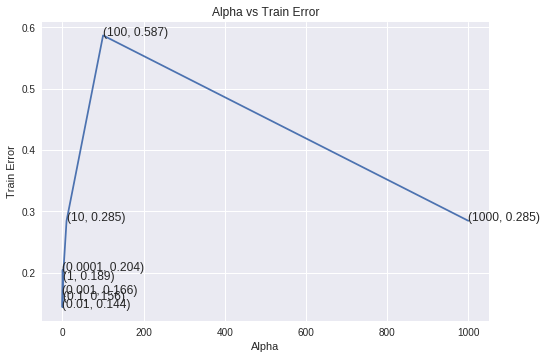

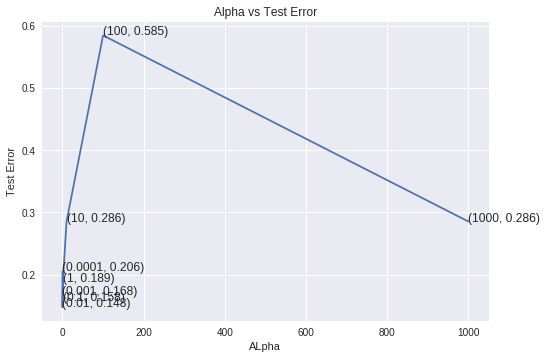

********************************************************************************
The value of alpha is                   :  [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
The train error for each alpha value is :  [0.204 0.166 0.144 0.156 0.189 0.285 0.587 0.285]
The test error for each alpha value is :  [0.206 0.168 0.148 0.158 0.189 0.286 0.585 0.286]


In [31]:
optimala_gs(standardized_train, y_train, standardized_test, y_test, standardized_cv, y_cv)

The optimal Alpha value found using RandomizedSearchCV is 0.01

The test accuracy of SVM for alpha = 0 is 84.941165%

The test precision of SVM for alpha = 0 is 86.639229%

The test recall of SVM for alpha = 0 is 93.311404%

The test f1 score of SVM for alpha = 0 is 89.851621%
**************************************************
             precision    recall  f1-score   support

   Negative       0.79      0.64      0.71     17134
   Positive       0.87      0.93      0.90     42864

avg / total       0.85      0.85      0.84     59998

**************************************************
[[10966  6168]
 [ 2867 39997]]


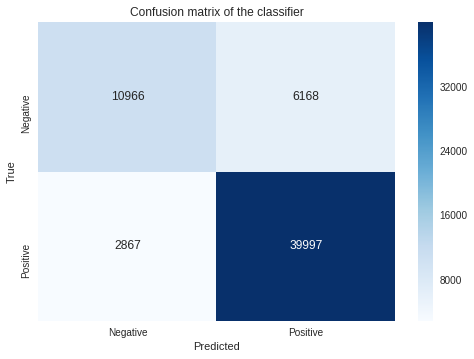

**************************************************
The True Positive Rate observed is 0.9331140350877193
The True Negative Rate observed is 0.6400140072370725
The False Positive Rate observed is 0.35998599276292753
The False Negative Rate observed is 0.0668859649122807
**************************************************
The stats observed for confusion matrix are:
population: 59998
P: 42864
N: 17134
PositiveTest: 46165
NegativeTest: 13833
TP: 39997
TN: 10966
FP: 6168
FN: 2867
TPR: 0.9331140350877193
TNR: 0.6400140072370725
PPV: 0.8663922885302718
NPV: 0.7927419937829827
FPR: 0.35998599276292753
FDR: 0.13360771146972814
FNR: 0.0668859649122807
ACC: 0.8494116470549018
F1_score: 0.8985162138179694
MCC: 0.6146286202670294
informedness: 0.5731280423247918
markedness: 0.6591342823132544
prevalence: 0.7144238141271376
LRP: 2.5920842861856324
LRN: 0.1045070329023361
DOR: 24.80296506559503
FOR: 0.2072580062170173


In [32]:
optimala_rs(standardized_train, y_train, standardized_test, y_test, 2)

# Conclusion

In [7]:
x = PrettyTable()
x.field_names = ["Model","Parameter Search","Hyper Parameter", "Test Accuracy","Precision","Recall","F1 Score"]
x.add_row(["Bag of Words","GridSearchCV","alpha = 1","87.07%", "86.76%", "96.59%", "91.42%"])
x.add_row(["","RandomizedSearchCV","alpha = 0.1","87.75%", "89.93%", "93.26%", "91.56%"])
x.add_row(["","","","","","",""])
x.add_row(["TFIDF","GridSearchCV","alpha = 1","85.08%", "86.10%", "94.29%", "90.01%"])
x.add_row(["","RandomizedSearchCV","alpha = 1","85.05%", "86.07%", "94.28%", "89.99%"])
x.add_row(["","","","","","",""])
x.add_row(["Avg Word2vec","GridSearchCV","alpha = 0.1","87.03%", "88.79%", "93.67%", "91.16%"])
x.add_row(["","RandomizedSearchCV","alpha = 0.01","87.39%", "89.47%", "93.33%", "91.36%"])
x.add_row(["","","","","","",""])
x.add_row(["TFIDF Word2vec","GridSearchCV","alpha = 0.01","85.08%", "87.18%", "92.76%", "89.88%"])
x.add_row(["","RandomizedSearchCV","alpha = 0.01","84.94%", "86.63%", "93.31%", "89.85%"])
x.add_row(["","","","","","",""])

print(x.get_string())
print('*'*120)

z = PrettyTable()
z.field_names = ["Words with higer importance for positive reviews","Words with higer importance for negative reviews"]
z.add_row(["great","dissapoint"])
z.add_row(["",""])
z.add_row(["love","worst"])
z.add_row(["",""])
z.add_row(["best","terribl"])
z.add_row(["",""])
z.add_row(["good","unfortun"])
z.add_row(["",""])
z.add_row(["perfect","return"])
z.add_row(["",""])
z.add_row(["delci","aw"])
z.add_row(["",""])
z.add_row(["excel","horribl"])
print(z.get_string())

+----------------+--------------------+-----------------+---------------+-----------+--------+----------+
|     Model      |  Parameter Search  | Hyper Parameter | Test Accuracy | Precision | Recall | F1 Score |
+----------------+--------------------+-----------------+---------------+-----------+--------+----------+
|  Bag of Words  |    GridSearchCV    |    alpha = 1    |     87.07%    |   86.76%  | 96.59% |  91.42%  |
|                | RandomizedSearchCV |   alpha = 0.1   |     87.75%    |   89.93%  | 93.26% |  91.56%  |
|                |                    |                 |               |           |        |          |
|     TFIDF      |    GridSearchCV    |    alpha = 1    |     85.08%    |   86.10%  | 94.29% |  90.01%  |
|                | RandomizedSearchCV |    alpha = 1    |     85.05%    |   86.07%  | 94.28% |  89.99%  |
|                |                    |                 |               |           |        |          |
|  Avg Word2vec  |    GridSearchCV    |   alph